In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model path
archive_path = '../../archive/model_spacy_processing_len3/'

In [4]:
# load dict and doc term matrixes
import pickle
obj_name_list = [
    'id2word', 
    'doc_term_matrix', 
    'doc_term_matrix_random_projections', 
    'doc_term_matrix_tfidf', 
    'doc_term_matrix_logentropy'
]
obj_list = []
for name in obj_name_list:
    with open(f'{archive_path}/model-server/dict_and_matrix/{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
        obj_list.append(obj)
        print(obj)

Dictionary(34220 unique tokens: ['great', 'lunch', 'maui', 'ocean', 'overlook']...)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
filepath_hi = f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
models_list

['lsi_8_topic_mode',
 'lsi_2_topic_mode',
 'lsi_5_topic_mode',
 'lsi_logentropy_topic_mode',
 'lsi_14_topic_mode',
 'lsi_11_topic_mode',
 'lda_2_topic_mode',
 'lda_5_topic_mode',
 'lda_8_topic_mode',
 'lda_11_topic_mode',
 'lda_14_topic_mode',
 'lsi_random_projections_topic_mode']

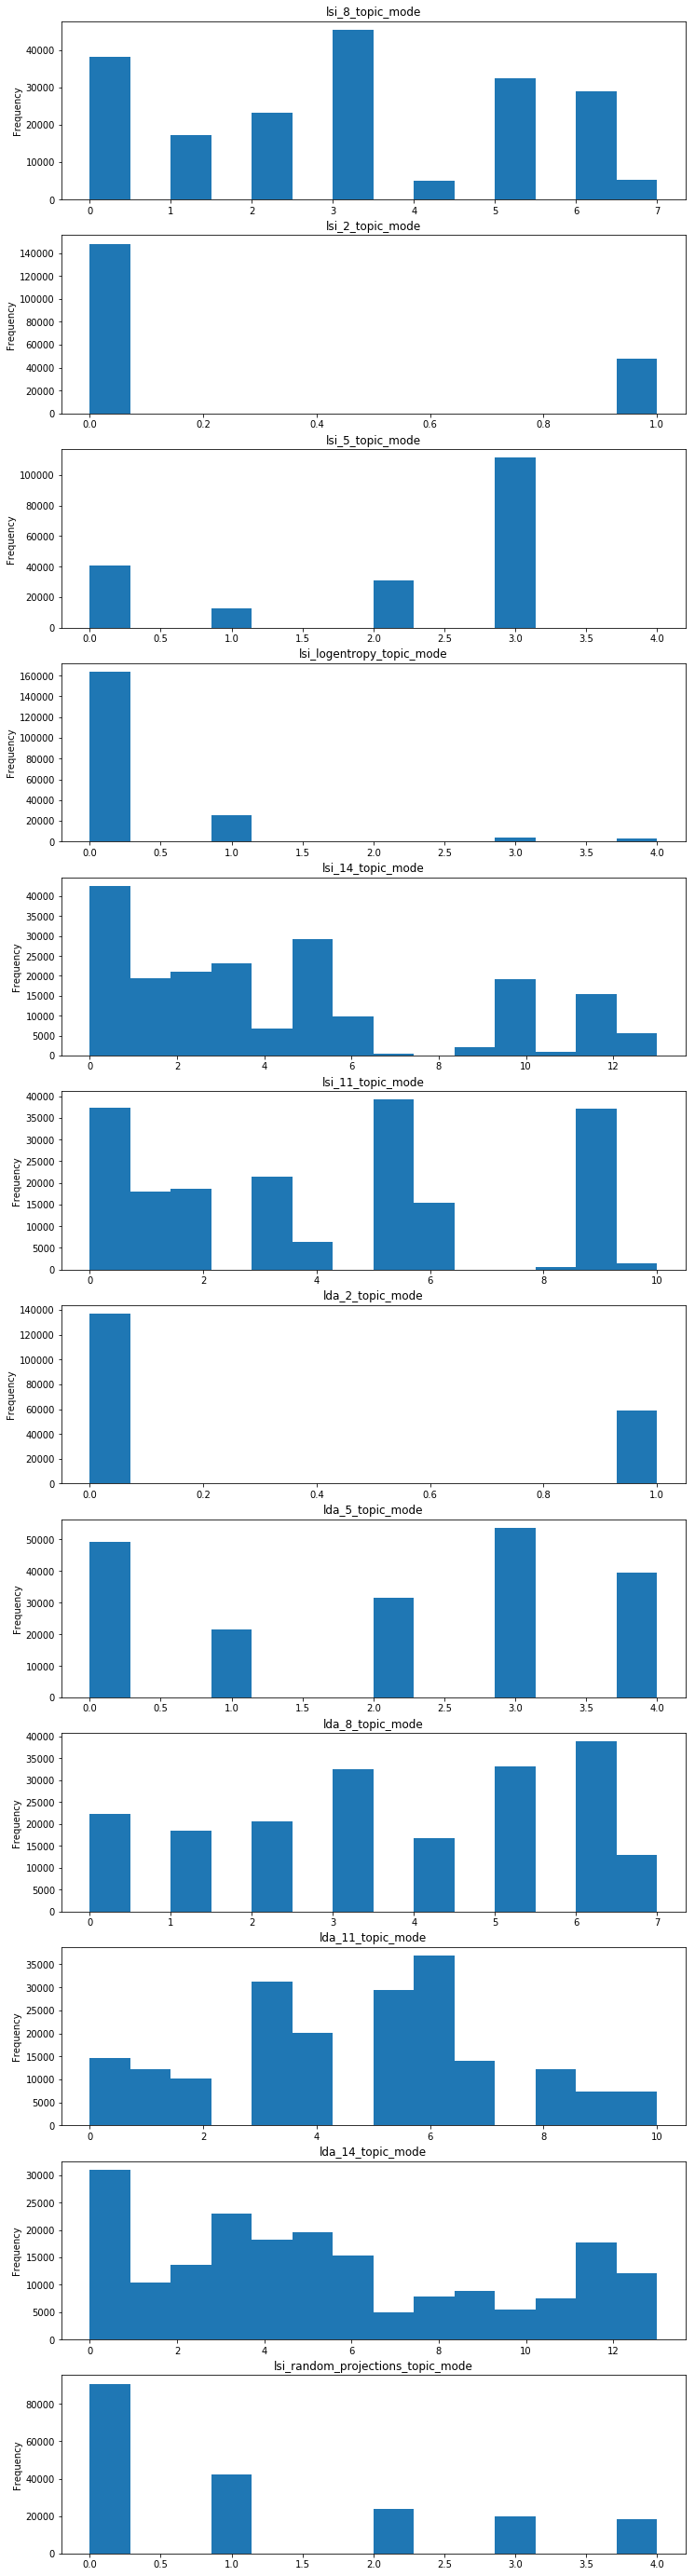

In [62]:
# topics value distribution
column_names = [i for i in df.columns if i.endswith('_mode')]
subplot_indexes = range(len(column_names))
fig, axes = plt.subplots(len(column_names), 1, figsize=(12,50))
for column_name, subplot_index in zip(column_names, subplot_indexes):
    index_row = 0 if subplot_index % 2 == 0 else 1
    df.loc[:,column_names[subplot_index]].plot(kind='hist', bins=14, ax=axes[subplot_index], title=column_name)

In [16]:
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
import itertools

loaded_models_list = []

for index, model in enumerate(models_list):
    model_path = f'{archive_path}/model-server/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    print(f'{index}: <', loaded_model)
    loaded_models_list.append(loaded_model)

0: < LsiModel(num_terms=34220, num_topics=8, decay=1.0, chunksize=20000)
1: < LsiModel(num_terms=34220, num_topics=2, decay=1.0, chunksize=20000)
2: < LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)
3: < LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)
4: < LsiModel(num_terms=34220, num_topics=14, decay=1.0, chunksize=20000)
5: < LsiModel(num_terms=34220, num_topics=11, decay=1.0, chunksize=20000)
6: < LdaModel(num_terms=34220, num_topics=2, decay=0.5, chunksize=2000)
7: < LdaModel(num_terms=34220, num_topics=5, decay=0.5, chunksize=2000)
8: < LdaModel(num_terms=34220, num_topics=8, decay=0.5, chunksize=2000)
9: < LdaModel(num_terms=34220, num_topics=11, decay=0.5, chunksize=2000)
10: < LdaModel(num_terms=34220, num_topics=14, decay=0.5, chunksize=2000)
11: < LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)


In [18]:
# rest of the code depends on here.
topic_model=loaded_models_list[7]
corpus=obj_list[1]
dictionary=obj_list[0]

In [66]:
# make a dataframe from words
topic_words = topic_model.show_topics(num_words=300, formatted=False)

topics_list = []
for (topic, word_list) in topic_words:
    temp = pd.DataFrame(word_list, columns=[f'{topic}_word', f'{topic}_prob'])
    topics_list.append(temp)
pd_topics = pd.concat(topics_list, axis=1)
pd_topics.to_csv(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics_words.csv', index=False)
pd_topics.head(10)

,0_word,0_prob,1_word,1_prob,2_word,2_prob,3_word,3_prob,4_word,4_prob
0,food,0.082548,have,0.040982,maui,0.040876,have,0.048747,place,0.036779
1,good,0.075428,lavender,0.026618,come,0.039504,good,0.028989,have,0.020196
2,great,0.065954,what,0.023057,have,0.038367,fish,0.024143,restaurant,0.018425
3,service,0.045355,order,0.020448,time,0.037371,fresh,0.019182,beach,0.016112
4,place,0.021202,could,0.018541,will,0.023996,burger,0.016806,pizza,0.015282
5,friendly,0.020757,menu,0.017686,visit,0.017897,which,0.016715,beautiful,0.013697
6,price,0.020417,think,0.016160,lunch,0.017672,order,0.015251,table,0.013696
7,amazing,0.019053,delicious,0.015754,dinner,0.017588,salad,0.015028,find,0.012419
8,experience,0.018830,special,0.015085,stop,0.015589,mahi,0.011888,view,0.012374
9,worth,0.018804,would,0.014750,make,0.015203,bread,0.011278,nice,0.012313


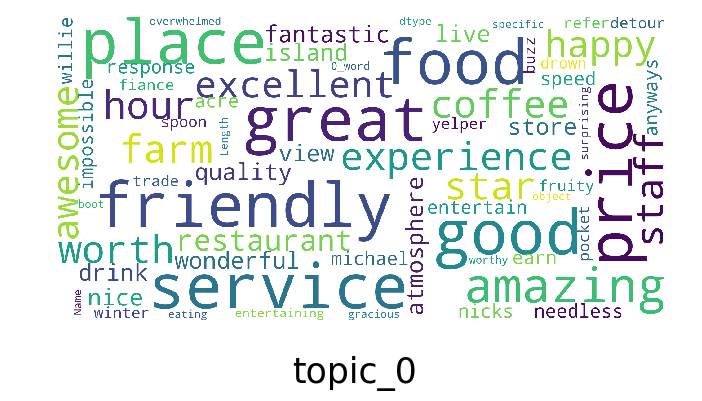

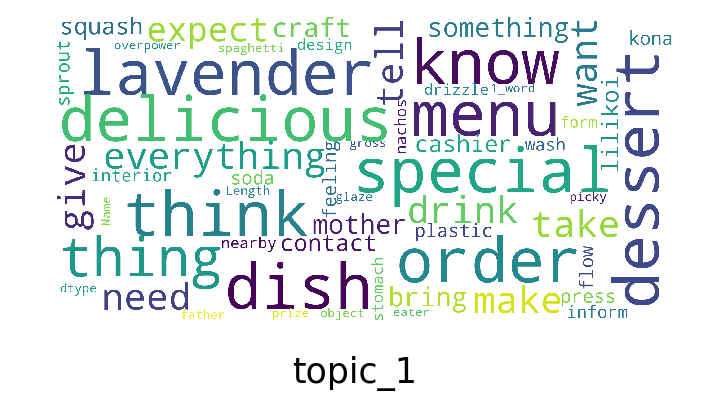

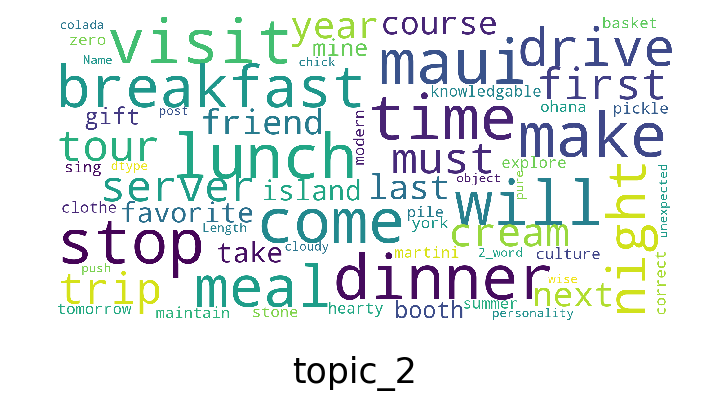

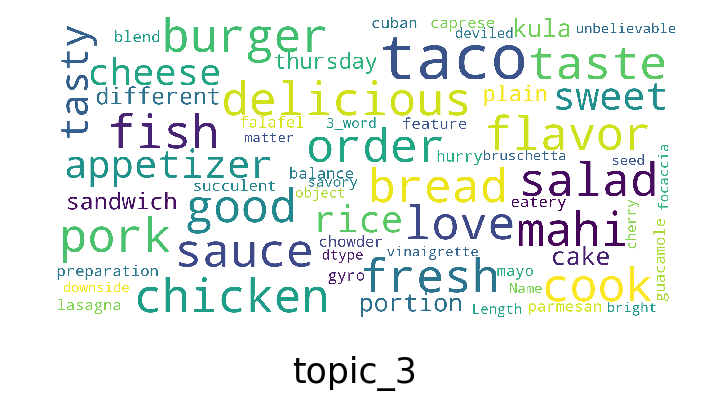

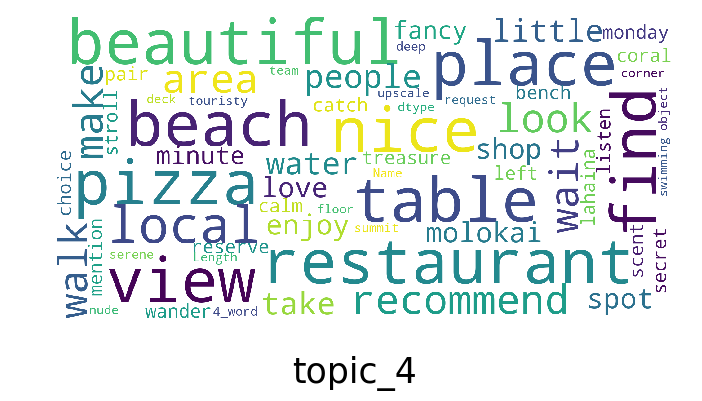

In [67]:
# words in the topics for selected model
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

for i in range(len(topics_list)):
    wordcloud = WordCloud(
            background_color='white',
            # stopwords=stopwords,
            max_words=400,
            max_font_size=40, 
            scale=5,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(pd_topics[f'{i}_word']))
    wordcloud.to_file(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topic_{i}.png')
    fig = plt.figure(1, figsize=(8, 8), dpi=100)    
    fig.suptitle(f'topic_{i}', fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=topic_model, corpus=corpus, dictionary=id2word)